# Training EfficientNet B0 with Focal Loss on The Model

## Library Imports

In [7]:
from autogluon.multimodal import MultiModalPredictor
from ray import tune
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import torch
import os

torch.set_float32_matmul_precision("medium")

## Data Imports

In [2]:
train_df = pd.read_csv("E:/Current_Workdir/palm-fruit-classification/data/clean/train_df.csv")
test_df = pd.read_csv("E:/Current_Workdir/palm-fruit-classification/data/clean/test_df.csv")

## Finetuning EfficientNet B0

Calculate class proportions for Focal Loss $\alpha$  
see [this](https://amaarora.github.io/posts/2020-06-29-FocalLoss.html) for details.

In [3]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_df["label_text"]), y=train_df["label_text"])
class_weights_list = class_weights.tolist()
class_weights_list

[2.1965174129353233,
 1.1964769647696476,
 0.44327309236947793,
 5.660256410256411,
 0.5145687645687645,
 3.003401360544218]

Set Training Folder Name

In [4]:
now = datetime.datetime.now()
timestamp_str = now.strftime("%Y-%m-%d_%H-%M-%S")
model_path = "../model/" + f"train_EfficientNetB0_{timestamp_str}"

In [5]:
model_path

'../model/train_EfficientNetB0_2024-12-04_18-34-06'

In [8]:
os.makedirs(model_path, exist_ok=True)

Defining Hyperparameters

In [9]:
hyperparameters = {
    "optimization.learning_rate": tune.loguniform(0.00005, 0.001),
    "optimization.max_epochs":tune.randint(5,20),
    "env.batch_size": tune.choice([8, 16, 32, 64, 128, 256]),
    #"env.batch_size": tune.qlograndint(8,128,2),
    "optimization.loss_function": "focal_loss",
    "optimization.focal_loss.alpha": class_weights_list,
    "optimization.focal_loss.gamma": tune.uniform(0, 1),
    "optimization.focal_loss.reduction": "sum",
    "model.timm_image.checkpoint_name": "efficientnet_b0",
    "optimization.optim_type": "adamw",
    "optimization.top_k_average_method": "best"
}

In [10]:
predictor = MultiModalPredictor(label="label_text", path=model_path, problem_type='multiclass', eval_metric="f1_macro")

In [11]:
hyperparameter_tune_kwargs = {
    "searcher": "bayes",
    "scheduler": "ASHA",
    "num_trials": 10
}

In [12]:
predictor.fit(
        train_data=train_df,
        hyperparameters=hyperparameters,
        hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
        # time_limit = 3600
)

=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          32
Pytorch Version:    2.4.1
CUDA Version:       12.4
Memory Avail:       109.08 GB / 127.91 GB (85.3%)
Disk Space Avail:   1456.93 GB / 1863.00 GB (78.2%)


Trial name,should_checkpoint,val_f1_macro
17bddcc2,True,0.162734
3685ee31,True,0.17651
37e50db5,True,0.146114
70373e39,True,0.144859
8f63fa16,True,0.147685
d2dd0b36,True,0.945998
ddf3e312,True,0.205554
e97db2e3,True,0.695118
ec5b624a,True,0.200542
f3bd4e54,True,0.179359


Removing non-optimal trials and only keep the best one.
e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\autogluon\multimodal\utils\checkpoint.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues

## Continue Training After Error

In [ ]:
# predictor = MultiModalPredictor.load(model_path)

In [ ]:
# predictor.fit(
#         train_data=train_df,
#         hyperparameters=hyperparameters,
#         hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
#         # time_limit = 3600
# )

## Evaluate on Test Dataset

In [13]:
scores = predictor.evaluate(test_df, metrics=["f1_macro", "f1_micro", "accuracy", "recall_macro", "precision_macro"])
scores

e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\lightning\pytorch\plugins\precision\amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 14.53it/s]


{'f1_macro': 0.8381600823320751,
 'f1_micro': 0.841688654353562,
 'accuracy': 0.841688654353562,
 'recall_macro': 0.8374415774778093,
 'precision_macro': 0.8497374144274414}

In [14]:
preds = predictor.predict(test_df)

e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\lightning\pytorch\plugins\precision\amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 18.10it/s]


In [15]:
true_labels = test_df['label_text']

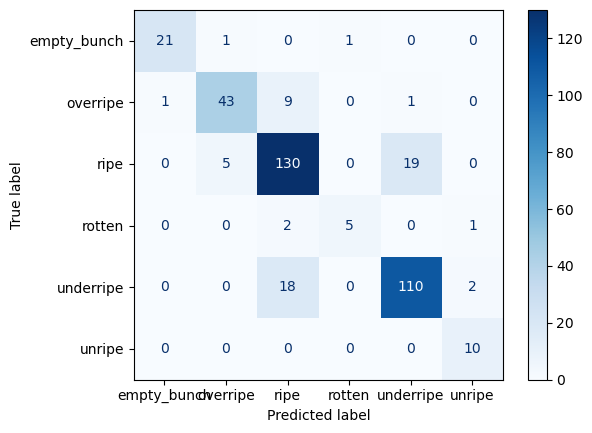

In [16]:
cm = confusion_matrix(true_labels, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=predictor.class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Inference Example

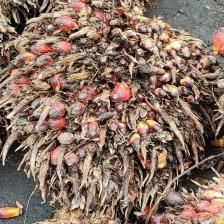

In [17]:
image_path = test_df.iloc[0]['image']
pil_img = Image.open(image_path)  # Use .open() instead of calling Image
display(pil_img)

In [18]:
predictions = predictor.predict({'image': [image_path]})
predictions

e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\lightning\pytorch\plugins\precision\amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


array(['overripe'], dtype=object)

In [19]:
proba = predictor.predict_proba({'image': [image_path]})
print(proba)

e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\lightning\pytorch\plugins\precision\amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s]
[[1.2341539e-03 9.9235690e-01 6.2263715e-03 6.5927006e-06 1.7169653e-04
  4.2899524e-06]]


In [20]:
feature = predictor.extract_embedding({'image': [image_path]})
print(feature[0].shape)

e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\lightning\pytorch\plugins\precision\amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 40.00it/s]
(1280,)


## Save Raw TIMM Format

In [21]:
predictor.dump_model(model_path + "/timm")

Model timm_image weights saved to ../model/train_EfficientNetB0_2024-12-04_18-34-06/timm\timm_image/pytorch_model.bin.
Timm config saved to ../model/train_EfficientNetB0_2024-12-04_18-34-06/timm\timm_image/config.json.


'../model/train_EfficientNetB0_2024-12-04_18-34-06/timm'